In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from IPython import display
from tensorflow.examples.tutorials.mnist import input_data
tfd = tf.contrib.distributions
seaborn.reset_orig()
plt.style.use('default')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/ashish/anaconda3/envs/tensor/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/ashish/anaconda3/envs/tensor/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/ashish/anaconda3/envs/tensor/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/ashish/anaconda3/envs/tensor/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/ashish/anaconda3/envs/tensor/lib/pytho

In [2]:
def make_encoder(data, code_size):
  x = tf.layers.flatten(data)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  loc = tf.layers.dense(x, code_size)
  scale = tf.layers.dense(x, code_size, tf.nn.softplus)
  return tfd.MultivariateNormalDiag(loc, scale)


In [3]:
def make_prior(code_size):
  loc = tf.zeros(code_size)
  scale = tf.ones(code_size)
  return tfd.MultivariateNormalDiag(loc, scale)


In [4]:
def make_decoder(code, data_shape):
  x = code
  x = tf.layers.dense(x, 256, tf.nn.relu)
  x = tf.layers.dense(x, 256, tf.nn.relu)
  logit = tf.layers.dense(x, np.prod(data_shape))
  logit = tf.reshape(logit, [-1] + data_shape)
  return tfd.Independent(tfd.MultivariateNormalDiag(logit),2)


In [5]:
def plot_online(epoch, codes, labels, samples, size=2):
  fig, ax = plt.subplots(
      ncols=1 + len(samples), figsize=((1 + len(samples)) * size, size))
  no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
  ax[0].set_ylabel('Epoch {}'.format(epoch))
  ax[0].scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
  ax[0].set_aspect('equal')
  ax[0].set_xlim(codes.min() - .1, codes.max() + .1)
  ax[0].set_ylim(codes.min() - .1, codes.max() + .1)
  ax[0].tick_params(axis='both', which='both', **no_ticks)
  for index, sample in enumerate(samples):
    ax[1 + index].imshow(sample, cmap='gray')
    ax[1 + index].tick_params(axis='both', which='both', **no_ticks)
  display.display(fig)
  plt.close()


In [6]:

data = tf.placeholder(tf.float32, [None, 28, 28])

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)


In [7]:

# Define the model.
prior = make_prior(code_size=32)
posterior = make_encoder(data, code_size=32)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

samples = make_decoder(prior.sample(15), [28, 28]).mean()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Epoch 1 elbo -7268560.0


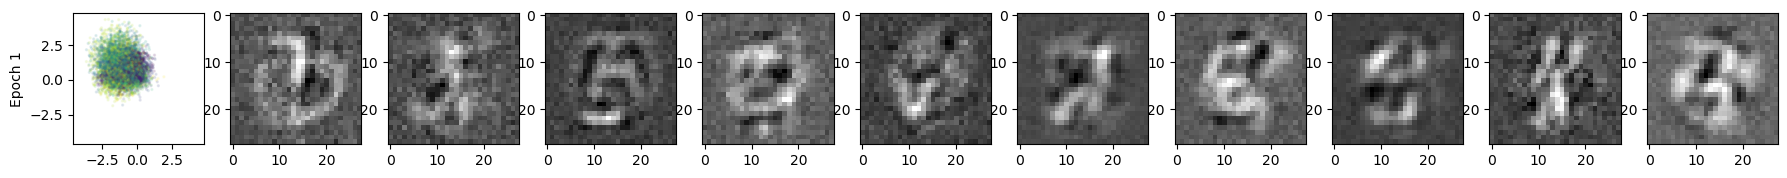

Epoch 5 elbo -7247590.0


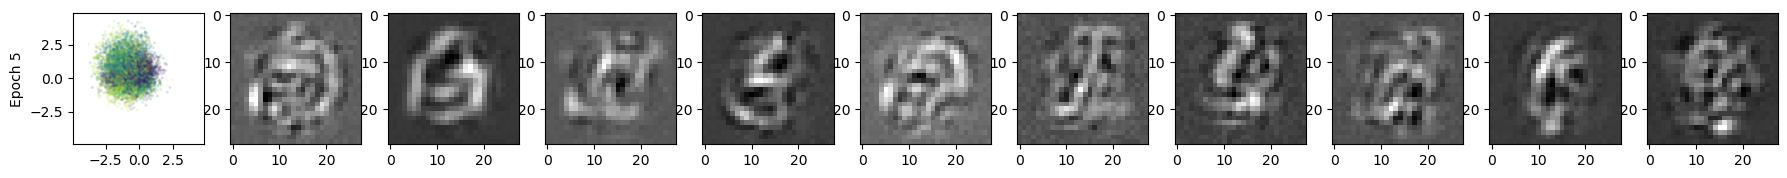

Epoch 25 elbo -7238926.5


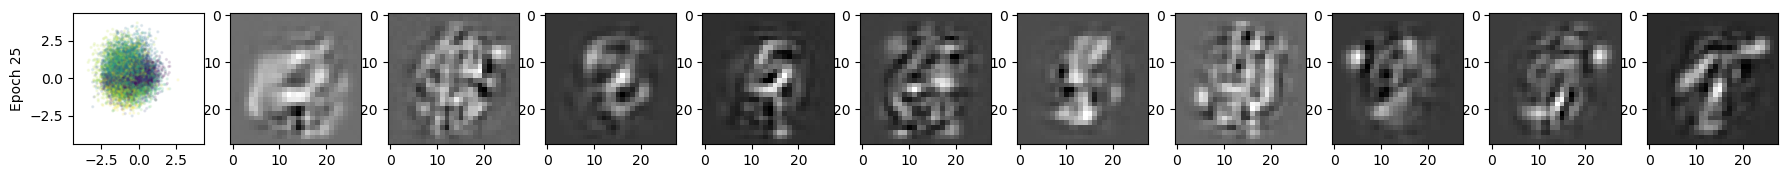

Epoch 50 elbo -7236621.0


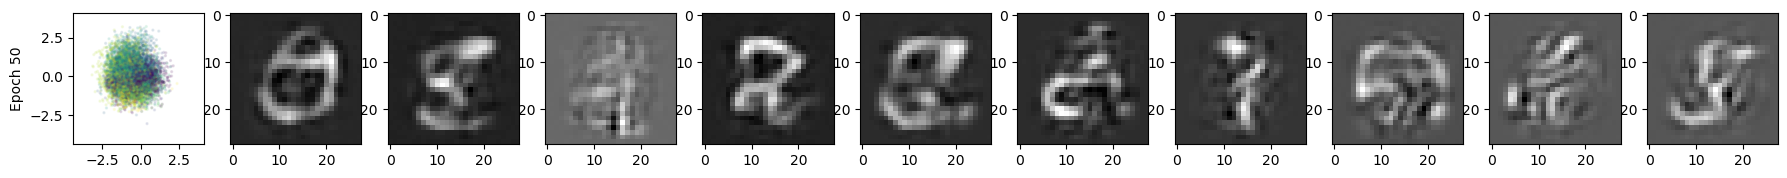

<Figure size 640x480 with 0 Axes>

In [8]:
samples = make_decoder(prior.sample(10), [28, 28]).mean()
epoch_el_32 = []
mnist = input_data.read_data_sets('MNIST_data/')
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for epoch in range(51):
    feed = {data: mnist.test.images.reshape([-1, 28, 28])}
    
    test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
    epoch_el_32.append((epoch,-1*test_elbo))
    if(epoch == 1 or epoch == 5or epoch == 25 or epoch == 50):
        print('Epoch', epoch, 'elbo', test_elbo)
        plot_online(epoch, test_codes, mnist.test.labels, test_samples)
    for _ in range(600):
      feed = {data: mnist.train.next_batch(128)[0].reshape([-1, 28, 28])}
      sess.run(optimize, feed)
plt.savefig('vae-mnist_5.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
latent_32 = epoch_el_32
ep = []
el = []
for epochs, elbo in latent_32:
    ep.append(epochs)
    el.append(elbo)

In [ ]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('-L_ELBO')
plt.plot(ep, el)
plt.title('Epoch vs -L_elbo')
plt.savefig('latent_32')

In [ ]:
latent_2 =  epoch_el
ep = []
el = []
for epochs, elbo in latent_2:
    ep.append(epochs)
    el.append(elbo)
    

In [ ]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('-L_ELBO')
plt.plot(ep, el)
plt.title('Epoch vs -L_elbo')
plt.savefig('latent_2')